In [2]:
import h5py
import healpy as hp
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

In [ ]:
scan_law_file = (
    "/mnt/ceph/users/gaia/scanninglaw/FullGaiaMissionScanningLaw/commanded_scan_law.csv"
)
df = pd.read_csv(
    scan_law_file,
    comment="#",
)
print(f"...done - loaded {len(df):,} rows")

# Turn the DataFrame where each row is a unique time for both FOVs into a new
# DataFrame with one row per scan sample and an FOV indicator column
new_data = {}
for col_name, col_data in df.items():
    if "fov1" in col_name:
        base_name = col_name[:-5]
        new_data[base_name] = np.concatenate(
            (col_data.to_numpy(), df[f"{base_name}_fov2"].to_numpy())
        )

        if "fov" not in new_data:
            new_data["fov"] = np.concatenate(
                (
                    np.full(col_data.size, 1, dtype=np.uint8),
                    np.full(col_data.size, 2, dtype=np.uint8),
                )
            )

    elif "fov2" in col_name:
        continue
    else:
        new_data[col_name] = np.concatenate((col_data.to_numpy(), col_data.to_numpy()))
df = pd.DataFrame(new_data)
mask = np.isfinite(df["ra"]) & np.isfinite(df["dec"])
df = df[mask].reset_index(drop=True)

df["time_bjd"] = df["bjd"]

# HACK:
# df["ra"] += 15.235235
# df["ra"] = df["ra"] % 360.0

...done - loaded 34,504,372 rows


In [56]:
GAIA_TIME_ORIGIN_JD = 2455197.5
bjd_range = (2456892.376, 2457901.865)
# bjd_range = (0, 1e10)

time_window_mask = (df["bjd"] >= (bjd_range[0] - GAIA_TIME_ORIGIN_JD)) & (
    df["bjd"] <= (bjd_range[1] - GAIA_TIME_ORIGIN_JD)
)
window_df = df[time_window_mask].reset_index(drop=True)

# Compute HEALPix pixels for valid observations
pix = hp.ang2pix(
    64,
    window_df["ra"].to_numpy(),
    window_df["dec"].to_numpy(),
    nest=False,
    lonlat=True,
)

In [57]:
# Find two high dec pixels on either side of ra=0 (four pixels total)
scans_ra, scans_dec = hp.pix2ang(64, np.arange(hp.nside2npix(64)), lonlat=True)
scans_ra[scans_ra >= 180] -= 360

_mask = (scans_dec > 60) & (scans_dec < 65)
val = scans_dec[_mask].min()
_mask = np.isclose(scans_dec, val)
# check_idx = np.where(_mask & (np.abs(scans_ra) < 10))[0]
check_idx = np.where(_mask & (np.abs(scans_ra) < 5))[0]
print(check_idx)

[3120 3121 3278 3279]


In [58]:
pix_dfs = [window_df[pix == idx].reset_index(drop=True) for idx in check_idx]

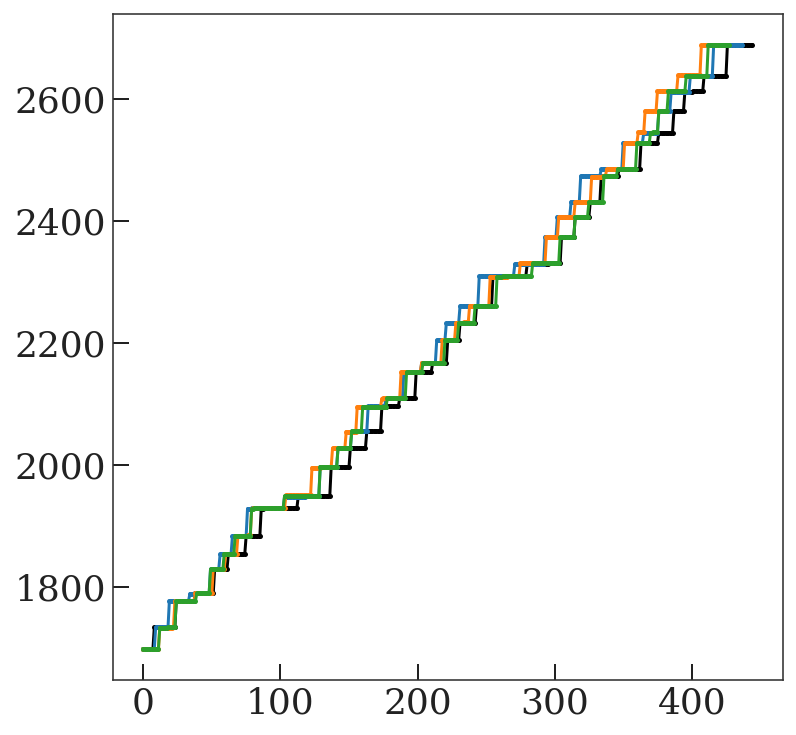

In [59]:
for pix_df in pix_dfs:
    plt.plot(np.sort(pix_df["time_bjd"].to_numpy()))

In [61]:
ROUGH_FOCAL_PLANE_TRANSIT_TIME = 0.000694


# def _get_subset(subset):
#     subset = subset.iloc[np.argsort(subset["time_bjd"])]

#     # Find unique scans by identifying gaps larger than the focal plane transit time
#     transit_mask = np.diff(subset["time_bjd"]) < ROUGH_FOCAL_PLANE_TRANSIT_TIME

#     # Get indices where a new scan segment starts: A new segment starts at index 0,
#     # and then after each contiguous block of False in transit_mask
#     gap_indices = np.where(~transit_mask)[0]
#     if gap_indices.size > 0:
#         block_ends = np.r_[np.where(np.diff(gap_indices) > 1)[0], gap_indices.size - 1]
#         scan_start_indices = np.concatenate([[0], gap_indices[block_ends] + 1])
#     else:
#         scan_start_indices = np.array([0])

#     return subset.iloc[scan_start_indices]

# def _get_subset(subset):
#     subset = subset.iloc[np.argsort(subset["time_bjd"])]
#     if len(subset) == 0:
#         return subset
#     time_diffs = np.diff(subset["time_bjd"].to_numpy())
#     large_gaps = time_diffs >= ROUGH_FOCAL_PLANE_TRANSIT_TIME
#     scan_start_indices = np.concatenate([[0], np.where(large_gaps)[0] + 1])
#     return subset.iloc[scan_start_indices]

def _get_subset(subset):
    sub_dfs = []
    for fov in [1, 2]:
        fov_mask = subset["fov"] == fov
        fov_subset = subset[fov_mask]

        fov_subset = fov_subset.iloc[np.argsort(fov_subset["time_bjd"])]
        if len(fov_subset) == 0:
            return fov_subset
        time_diffs = np.diff(fov_subset["time_bjd"].to_numpy())
        large_gaps = time_diffs >= ROUGH_FOCAL_PLANE_TRANSIT_TIME
        scan_start_indices = np.concatenate([[0], np.where(large_gaps)[0] + 1])

        sub_dfs.append(fov_subset.iloc[scan_start_indices])

    return pd.concat(sub_dfs)

In [62]:
sub_dfs = [_get_subset(dd) for dd in pix_dfs]
[len(sub_df) for sub_df in sub_dfs]

[118, 119, 96, 99]

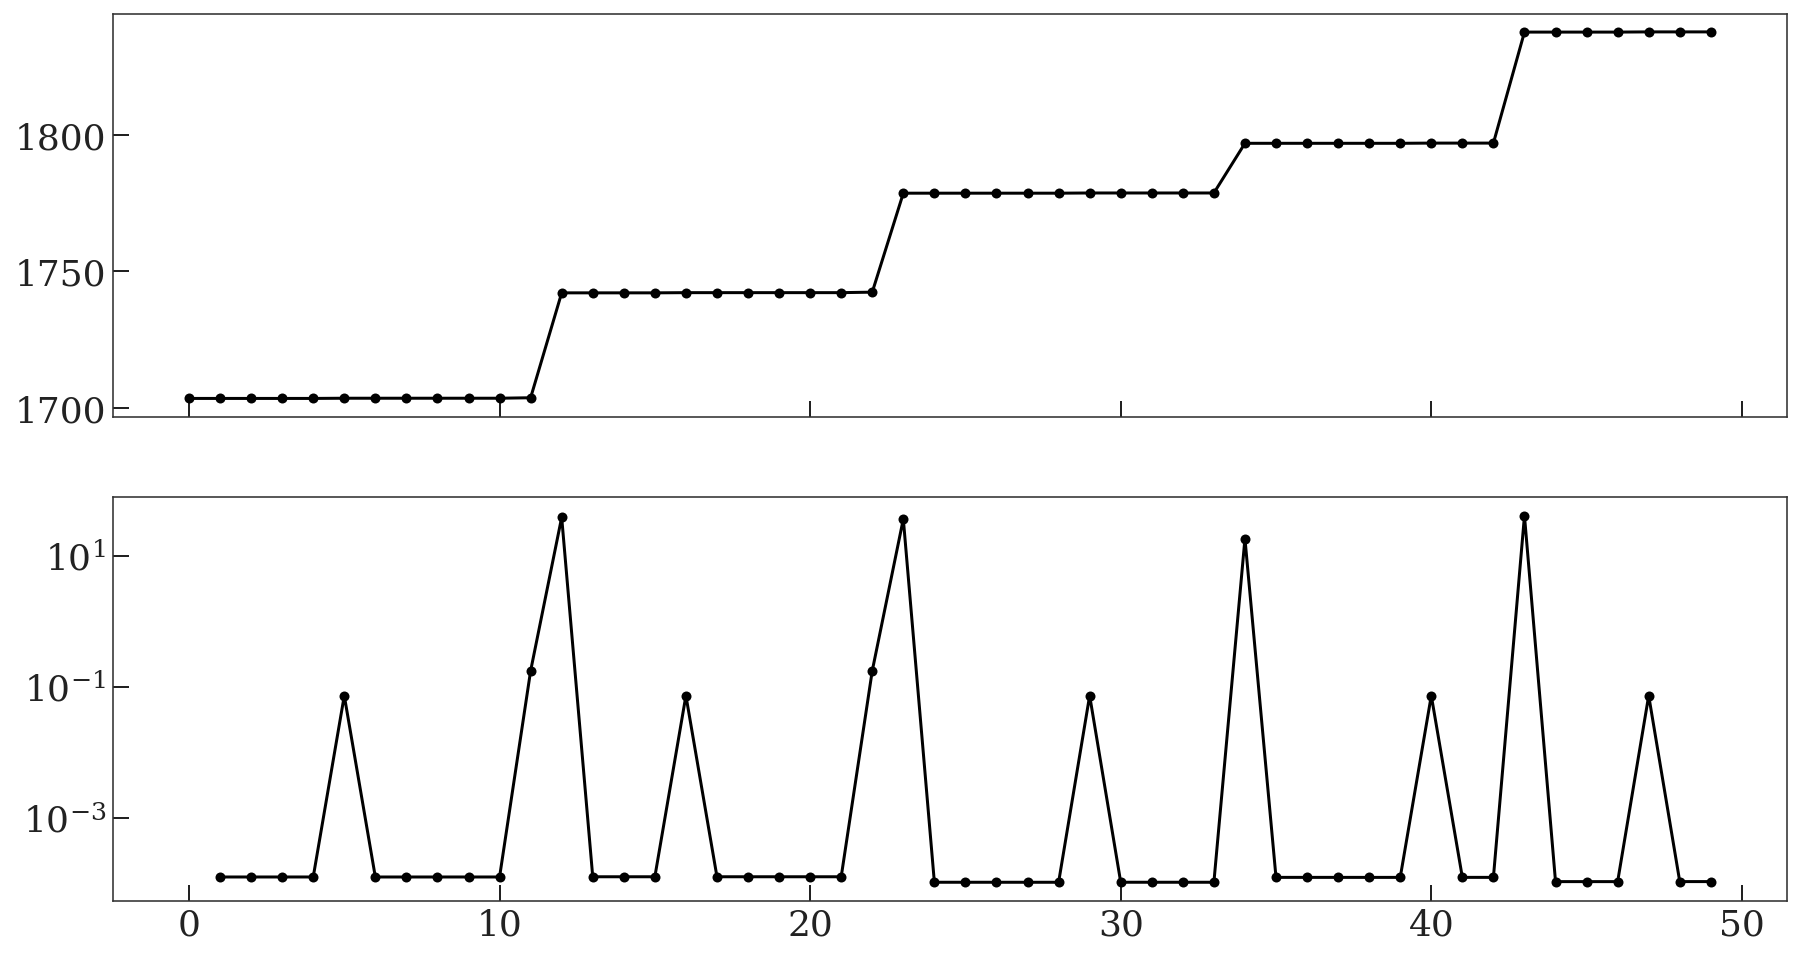

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(15, 8), sharex=True)
axes[0].plot(test[:50], marker="o")
axes[1].plot(np.arange(1, 50), np.diff(test[:50]), marker="o")
axes[1].set_yscale("log")
# plt.xlim(0, 50)

In [ ]:
rough_focal_plane_transit_time

np.float64(0.0006944444444444444)

In [ ]:
# transit_mask = np.concatenate([[True], np.diff(test) < rough_focal_plane_transit_time])
transit_mask = np.diff(test) < rough_focal_plane_transit_time

# Get indices where a new scan segment starts
# A new segment starts at index 0, and at the first index after each contiguous block of False in transit_mask
gap_indices = np.where(~transit_mask)[0]

# Take the last index after each contiguous block of False
if gap_indices.size:
    block_ends = np.r_[np.where(np.diff(gap_indices) > 1)[0], gap_indices.size - 1]
    scan_start_indices = np.concatenate([[0], gap_indices[block_ends] + 1])
else:
    scan_start_indices = np.array([0])

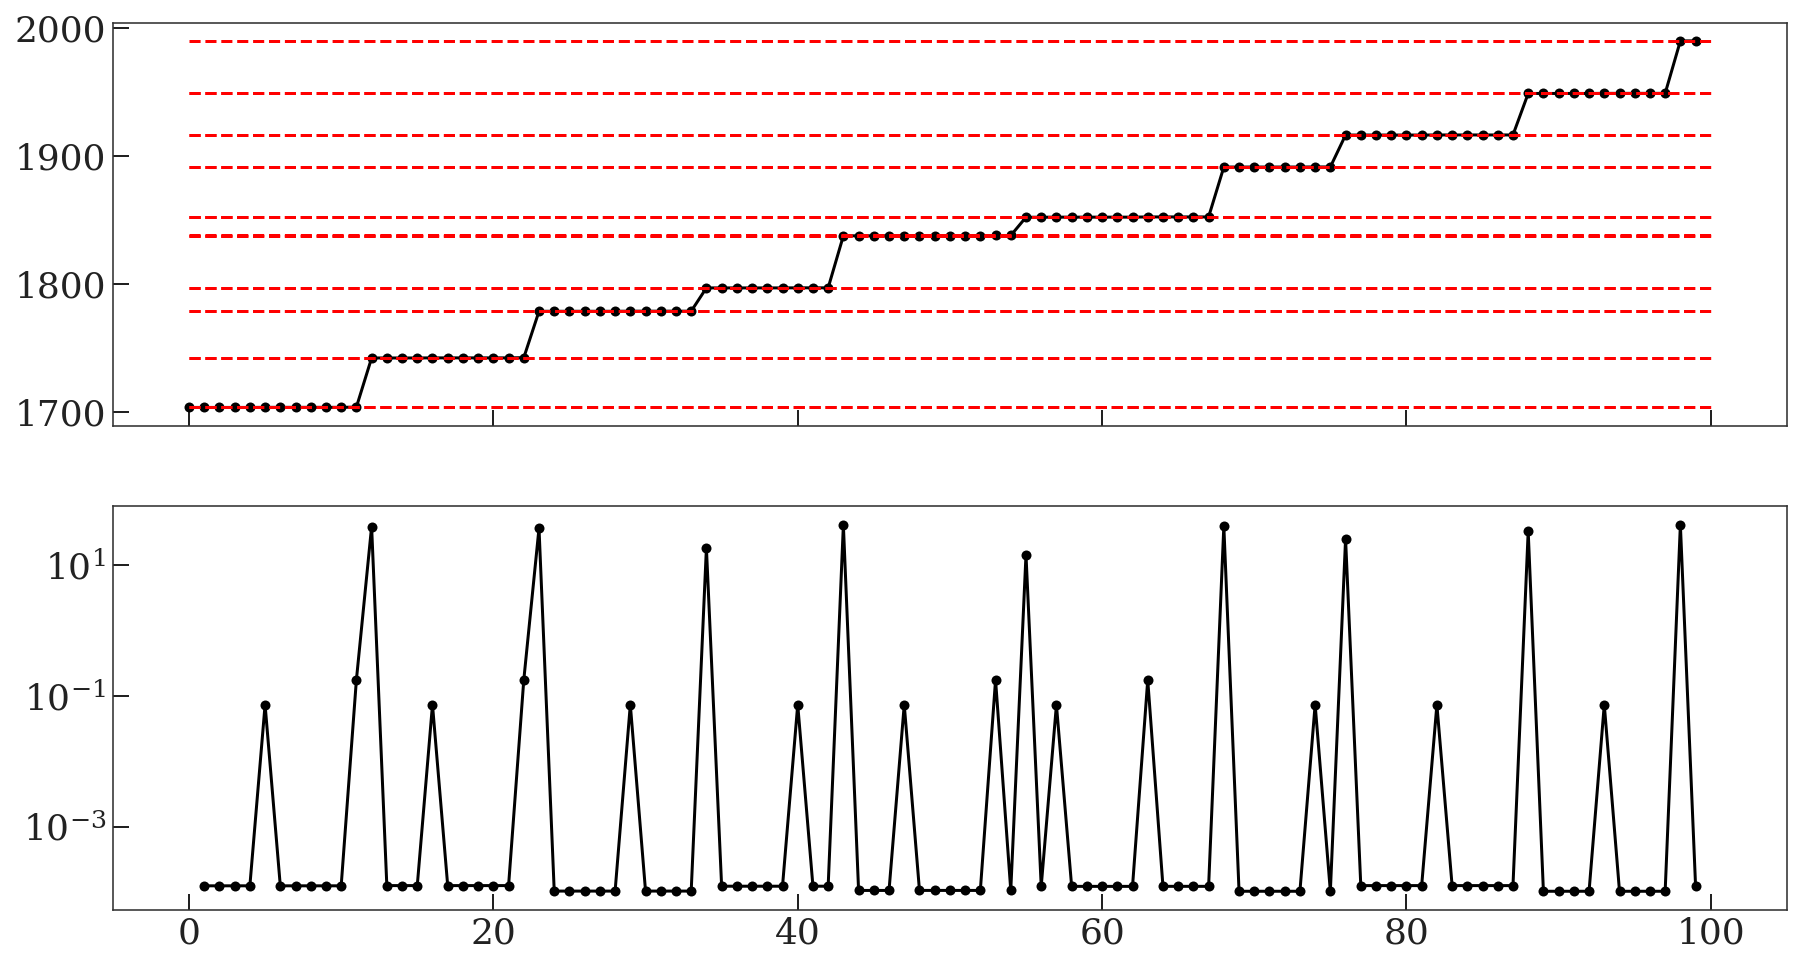

In [ ]:
max_idx = 100

fig, axes = plt.subplots(2, 1, figsize=(15, 8), sharex=True)
axes[0].plot(test[:max_idx], marker="o")
axes[1].plot(np.arange(1, max_idx), np.diff(test[:max_idx]), marker="o")
axes[1].set_yscale("log")
axes[0].hlines(
    test[scan_start_indices[scan_start_indices < max_idx]],
    xmin=0,
    xmax=max_idx,
    colors="r",
    linestyles="dashed",
)
# plt.xlim(0, 50)

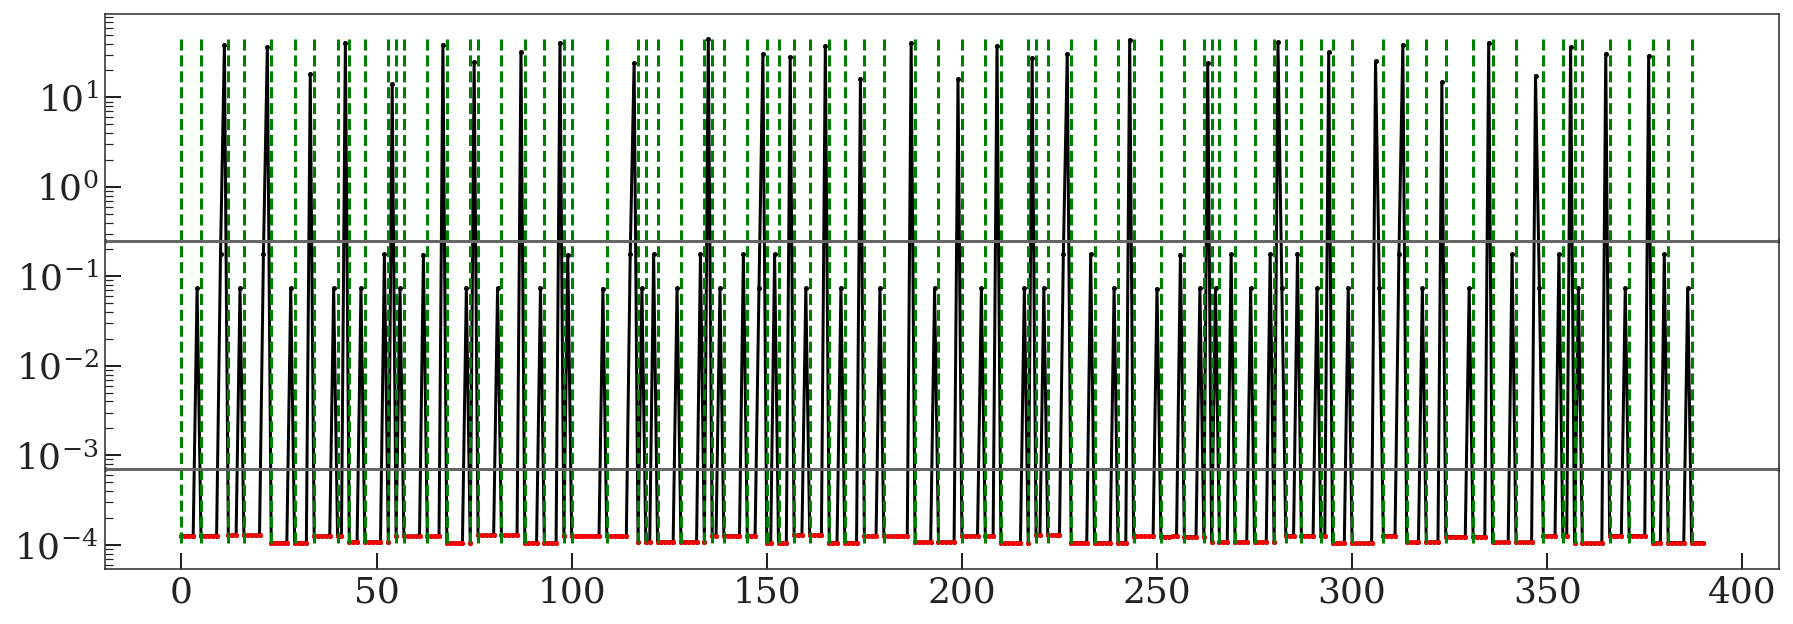

In [ ]:
idx = np.arange(len(test) - 1)

plt.figure(figsize=(15, 5))
plt.plot(idx, np.diff(test))
plt.plot(idx[transit_mask], np.diff(test)[transit_mask], ls="none", color="r")
plt.vlines(
    scan_start_indices,
    ymin=np.min(np.diff(test)),
    ymax=np.max(np.diff(test)),
    colors="g",
    linestyles="dashed",
)
plt.plot()
plt.yscale("log")
plt.axhline(0.25)
plt.axhline(7e-4)
# plt.xlim(0, 50)